In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

In [2]:
def num_check(col):  # визуализация и проверка выбросов числовых признаков
    print('Выбросы для: ' + col)
    data[col].hist(bins=25)
    plt.show()
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data_min = Q1 - 1.5 * IQR
    data_max = Q3 + 1.5 * IQR
    data_sum = (data[col] < data_min).sum() + (data[col] > data_max).sum()
    print("Всего выбросов:", data_sum, " Минимум:",
          data_min, " Максимум:", data_max)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [3]:
RANDOM_SEED = 37
VAL_SIZE = 0.2

# Setup

In [4]:
data_train = pd.read_csv('all_auto_ru_09_09_2020.csv')
data_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# EDA

In [5]:
data_train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

в прайсе присутсвуют нулевые значения, удалим их до объединения датасетов

In [7]:
data_train = data_train[pd.notna(data_train['price'])]

In [8]:
data_test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [10]:
sample_submission.head()

,sell_id,price
0,1100575026,0
1,1100549428,0
2,1100658222,0
3,1100937408,0
4,1101037972,0


### Легко видеть разное колличество колонок, посмотрим какие различаются
#### Уникальные колонки у train:

In [11]:
set(data_train.columns).difference(data_test.columns)

{'hidden', 'model', 'price', 'start_date', 'Комплектация'}

#### Уникальные колонки у test:

In [12]:
set(data_test.columns).difference(data_train.columns)

{'car_url',
 'complectation_dict',
 'equipment_dict',
 'image',
 'model_info',
 'model_name',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen',
 'vendor'}

### На данном этапе ознакомившись с датасетами можно выделить:

1) hiden - пустой столбец и от него можно избавиться за ненадобностью 

2) model и model_name один и тот же признак

3) price - который нам нужен есть только в train, что нормально, ведь нам нет нужды обучать модель на тестовой выборке

4) комплектация и complectation_dict - один и тот же признак, который сам по себе нам не сильно поможет, но из него можно будет вырвать дополнительные признаки

5) start_date - так же как и parsing_unixtime является признаком со временем, вероятно стоит взглянуть на них поближе, отдельно

6) car_url - ссылка на страницу продажи автомобиля, для обучения бесполезна

7) equipment_dict - второй словарь в которого нет альтернативы в train, так что от него избавимся

8) image - ссылка на фото машины, избавляемся

9) model_info - дополнительная и не особо нужная информация  названии модели, которой нет в test, избавляемся

10) priceCurrency - признак который мог бы быть проблемой, если бы все продажи не происходили в рублях, избавляемся

11) sell_id - не нужен при обучении, но нужен для сабмишена

12) super_gen - словарь который судя по всему описывает двигатель, уже "разобран" на признаки типа fuelType и enginePower, удалим за ненадобностью

13) vendor - место в котором машина была произведина, лишь 2 варианта япония и европа, в целом признак интересный, вероятно стоит попробывать заполнить пропуски используя названия машин

#### Удалим/переименуем столбцы

In [13]:
data_train = data_train.drop(['hidden'], axis=1)
data_train.rename(columns={'Комплектация': 'complectation_dict'}, inplace=True)

In [14]:
data_test = data_test.drop(['car_url', 'equipment_dict', 'image',
                           'model_info', 'priceCurrency', 'super_gen'], axis=1)
data_test.rename(columns={'model_name': 'model'}, inplace=True)

### Признаки start_date и parsing_unixtime

In [15]:
data_test['parsing_unixtime'] = pd.to_datetime(
    data_test['parsing_unixtime'], unit='s')

In [16]:
print('Интвервалы start_date :' + data_train.start_date.min() +
      ' ' + data_train.start_date.max())
print('Интвервалы parsing_unixtime :')
print(data_test['parsing_unixtime'].min())
print(data_test['parsing_unixtime'].max())

Интвервалы start_date :2014-06-10T06:27:00Z 2020-09-09T10:49:25Z
Интвервалы parsing_unixtime :
2020-10-19 11:35:06
2020-10-26 11:04:24


#### Посмотрев на значения, можно сказать, что это разные признаки, а не один, тем самым удаляем оба признака. У нас нет нужды в признаках, в которые есть в одном датасете и отсутсвуют в другом без возможности заполнения.


In [17]:
data_train = data_train.drop(['start_date'], axis=1)
data_test = data_test.drop(['parsing_unixtime'], axis=1)

### Объединим датасеты

In [18]:
# Перед тем как объединить датасеты для анализа данных "помечаем" их, чтобы разделить в последствии
data_train['Temp'] = 1
data_test['Temp'] = 0
data = data_test.append(data_train, sort=False).reset_index(drop=True)

#### Поменяем название столбцов на более удобные

In [19]:
data.columns = ['body_type', 'brand', 'color', 'complectation_dict', 'description',
                'engine_displacement', 'engine_power', 'fuel_type', 'mileage', 'model_date',
                'model', 'name', 'number_of_doors', 'production_date', 'sell_id',
                'vehicle_configuration', 'vehicle_transmission', 'vendor', 'amount_of_owners',
                'car_ownership_time', 'pts', 'drive', 'wheel', 'condition', 'cleared_by_customs', 'temp',
                'price']

Так же удалим description, признак бесполезен

In [20]:
data = data.drop(['description'], axis=1)

In [21]:
data.head()

,body_type,brand,color,complectation_dict,engine_displacement,engine_power,fuel_type,mileage,model_date,model,...,vendor,amount_of_owners,car_ownership_time,pts,drive,wheel,condition,cleared_by_customs,temp,price
0,лифтбек,SKODA,синий,NaN,1.2 LTR,105 N12,бензин,74000,2013.0,OCTAVIA,...,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
1,лифтбек,SKODA,чёрный,NaN,1.6 LTR,110 N12,бензин,60563,2017.0,OCTAVIA,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...",1.8 LTR,152 N12,бензин,88000,2013.0,SUPERB,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
3,лифтбек,SKODA,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",1.6 LTR,110 N12,бензин,95000,2013.0,OCTAVIA,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
4,лифтбек,SKODA,белый,NaN,1.8 LTR,152 N12,бензин,58536,2008.0,OCTAVIA,...,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123654 entries, 0 to 123653
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   body_type              123653 non-null  object 
 1   brand                  123654 non-null  object 
 2   color                  123654 non-null  object 
 3   complectation_dict     95386 non-null   object 
 4   engine_displacement    123653 non-null  object 
 5   engine_power           123653 non-null  object 
 6   fuel_type              123654 non-null  object 
 7   mileage                123654 non-null  int64  
 8   model_date             123653 non-null  float64
 9   model                  123654 non-null  object 
 10  name                   123653 non-null  object 
 11  number_of_doors        123653 non-null  float64
 12  production_date        123654 non-null  int64  
 13  sell_id                34686 non-null   float64
 14  vehicle_configuration  123653 non-nu

#### Легко видеть, что в признаках присутствуют пропуски.
### Пройдемся по всем признакам и проведем первичную обработку.
#### Создадим словари для типов признаков

In [23]:
data_num = []  # колличественные признаки
data_cat = []  # категориальные признаки
data_bin = []  # бинарные признаки

#### body_type
Категориальный признак

In [24]:
data.body_type.value_counts()

Внедорожник 5 дв.                   31748
Седан                               30458
седан                               13147
внедорожник 5 дв.                   12228
Хэтчбек 5 дв.                        8613
                                    ...  
Родстер Roadster                        1
Хэтчбек 5 дв. Runx                      1
Пикап Полуторная кабина Rap Cab         1
Седан SRT                               1
Пикап Полуторная кабина Club Cab        1
Name: body_type, Length: 192, dtype: int64

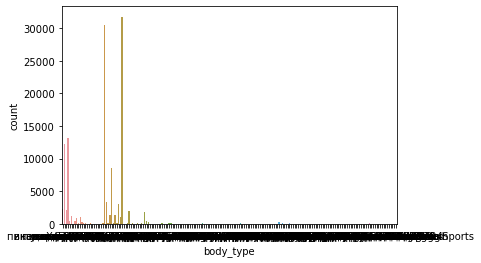

In [25]:
sns.countplot(x=data.body_type)
plt.show()

In [26]:
print('Уникальных значений: ' + str(len(data.body_type.unique())))

Уникальных значений: 193


График из-за колличества переменных получился не особо красивый, но по нему легко видеть что огромное колличество переменных используется редко, необходимо изменить признак, либо удалив редко встречающиеся переменные, либо объединить переменные так, чтобы разброс был не таким сильным.
Поделим корпуса на типы.

In [27]:
data.body_type = data.body_type.apply(
    lambda row: str(row).lower().split()[0].strip())
data.body_type.value_counts()

седан            44974
внедорожник      44736
хэтчбек          13399
лифтбек           5644
универсал         4719
минивэн           3412
компактвэн        2566
купе              2119
пикап              905
купе-хардтоп       353
кабриолет          258
родстер            250
фургон             231
микровэн            31
седан-хардтоп       29
лимузин             12
тарга               11
фастбек              4
nan                  1
Name: body_type, dtype: int64

In [28]:
data = data[data.body_type != 'nan']  # удаляем единственный nan
# добавляем body_type в список категориальных признаков
data_cat.append('body_type')

Уместили 193 значения в 16, в будущем, для отимизации, возможно нужно будет объединить их еще сильнее или удалить редко встречающиеся, но пока что оставим как есть

### brand
Еще один категориальный признак, для корректного заполнения пропусков в vendor пока что не будем удалять редко встречающиеся бренды, пропусков нет

In [29]:
data.brand.value_counts()

MERCEDES      12159
BMW           11838
VOLKSWAGEN    11515
NISSAN        10143
TOYOTA         8708
AUDI           7491
MITSUBISHI     6762
HYUNDAI        5710
KIA            5600
SKODA          5536
FORD           4780
CHEVROLET      3615
VOLVO          3525
OPEL           3100
RENAULT        2700
HONDA          2322
MAZDA          2296
INFINITI       1907
LEXUS          1880
PEUGEOT        1627
LAND_ROVER     1616
CITROEN        1140
DAEWOO         1034
SUBARU          930
SUZUKI          865
SSANG_YONG      714
PORSCHE         709
CHERY           562
JEEP            480
GREAT_WALL      418
DODGE           417
CHRYSLER        321
CADILLAC        319
JAGUAR          311
MINI            310
GEELY           293
Name: brand, dtype: int64

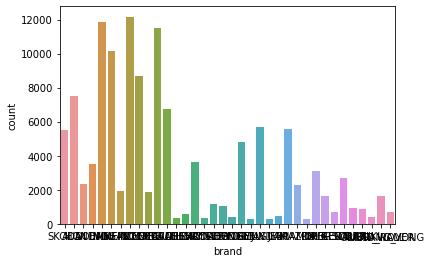

In [30]:
sns.countplot(x=data.brand)
plt.show()

In [31]:
data_cat.append('brand')

#### color
Пропусков нет,категориальный признак, часть из них в шестнадцатеричном коде, часть написана на русском, стоит привести их к одному типу.

In [32]:
data.color.value_counts()

040001         25094
FAFBFB         15761
CACECB         11282
чёрный         11010
97948F         10773
0000CC          8825
белый           6133
EE1D19          4489
серебристый     4113
серый           3984
200204          3562
синий           3289
007F00          2592
C49648          1841
красный         1531
коричневый      1501
22A0F8          1392
зелёный          952
DEA522           771
660099           746
FFD600           699
бежевый          639
4A2197           600
FF8649           515
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
FFC0CB            25
розовый           13
Name: color, dtype: int64

In [33]:
colors = {'чёрный': '040001', 'белый': 'FAFBFB', 'серый': '97948F', 'серебристый': 'CACECB', 'синий': '0000CC', 'коричневый': '200204',
          'красный': 'EE1D19',  'зелёный': '007F00', 'бежевый': 'C49648', 'голубой': '22A0F8', 'пурпурный': '660099', 'золотистый': 'DEA522',
          'фиолетовый': '4A2197', 'жёлтый': 'FFD600', 'оранжевый': 'FF8649', 'розовый': 'FFC0CB'}
data.color.replace(to_replace=colors, inplace=True)
data.color.value_counts()

040001    36104
FAFBFB    21894
CACECB    15395
97948F    14757
0000CC    12114
EE1D19     6020
200204     5063
007F00     3544
C49648     2480
22A0F8     1849
DEA522     1037
660099     1000
FFD600      893
4A2197      819
FF8649      646
FFC0CB       38
Name: color, dtype: int64

In [34]:
data_cat.append('color')

### engine_displacement
Рабочий объем двигателя, оторбражается в литрах, дюймах, вольтах и т.п. Очевидно, что будет крайне высокая корреляция с мощностью и лошадиными силами, удалим этот признак. 

In [35]:
data = data.drop(['engine_displacement'], axis=1)

#### engine_power
Еще один колличественный признак, нужнающийся в обработке. Половина значений написана как str и имеет приписку N12, вторая половина float, приведем к одному типу.

In [36]:
data.engine_power = data.engine_power.apply(
    lambda row: row[:-4] if re.search('N12', str(row)) else row)
data.engine_power = data.engine_power.astype('float64')
data_num.append('engine_power')

Посмотрим на выбросы

Выбросы для: engine_power


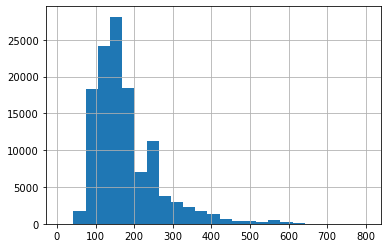

Всего выбросов: 5793  Минимум: -22.5  Максимум: 349.5


In [37]:
num_check('engine_power')

Попробуем уменьшить колличество выбросов, посмотрим сколько машин в тестовой подборке имеют "мощность" больше 350

In [38]:
data[(data['temp'] == 0) & (data['engine_power'] > 350)].engine_power.count()

1867

In [39]:
data[(data['temp'] == 0)].engine_power.max()

639.0

Итак, в тестовой выборке так же есть выбросы. Попробуем прологарифмировать

Выбросы для: engine_power


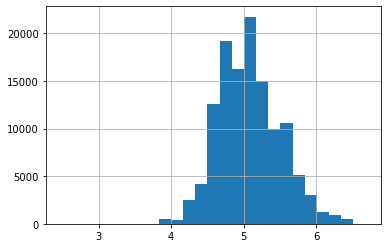

Всего выбросов: 1447  Минимум: 3.898924360950063  Максимум: 6.223618396991669


In [40]:
data['engine_power'] = np.log(data['engine_power'] + 1)
num_check('engine_power')

Удалим из датасета все выбросы, больше максимальных и меньше минимальных значений тестовой выборки.

In [41]:
eng_max = data[(data['temp'] == 0)].engine_power.max()
eng_min = data[(data['temp'] == 0)].engine_power.min()
data = data[(data['engine_power'] < eng_max) |
            (data['engine_power'] > eng_min)]

#### fuel_type
категориальный признак, самые непопулярные типы встречаются в тестовой подборке.

In [42]:
data.fuel_type.value_counts()

бензин     103311
дизель      19641
гибрид        517
электро       166
газ            18
Name: fuel_type, dtype: int64

In [43]:
data_test.fuelType.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

In [44]:
data_cat.append('fuel_type')

#### Mileage
Колличественный признак, выбросы есть, пропусков нет.

Выбросы для: mileage


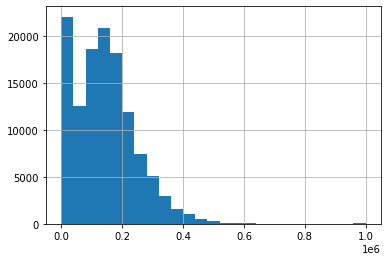

Всего выбросов: 2269  Минимум: -126620.0  Максимум: 395972.0


In [45]:
num_check('mileage')

Из графика видно, что причина наличия выборосов кроется в новых машинах, у которых нет пробега. Отсюда направшивается так же новый признак, так как использвали машину или нет, очевидно влияет на цену.

In [46]:
data[(data['temp'] == 0)].mileage.min()

1

Увы, в новом признаке не будет смысла, так как все машины имеют пробег. Удалим машины без пробега, это должно помочь с выбросами, так же благоприятно повлиять на модель в целом, так как опять же факт того, что машина новая и без пробега поднимает ее цену.

In [47]:
data = data[data.mileage > 0]

In [48]:
data_num.append('mileage')

Заодно добавим новый признак, машины, у которых пробег больше 100 тысяч киллометров

In [49]:
data['mileage_over_100'] = data.mileage.apply(
    lambda row: 1 if row > 100000 else 0)
data_bin.append('mileage_over_100')

In [50]:
data['mileage_over_100'].value_counts()

1    79464
0    30620
Name: mileage_over_100, dtype: int64

#### model_date          
Дата создание модели автомобиля. Есть выборосы, но их не много и они вероятно являются реальными данными.

Выбросы для: model_date


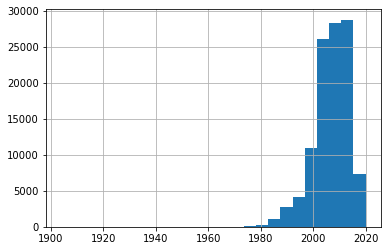

Всего выбросов: 3887  Минимум: 1992.0  Максимум: 2024.0


In [51]:
num_check('model_date')

In [52]:
data_num.append('model_date')

#### model
Модели автомобилей,категориальный признак,уникальных значений довольно много. Вероятно стоит заменить редко встречающиеся на "other".

In [53]:
len(data.model.unique())

1095

In [54]:
len(data_test.model.unique())

544

In [55]:
data['model'].value_counts()

OCTAVIA     2772
FOCUS       2458
5ER         2377
PASSAT      2045
E_KLASSE    1906
            ... 
XT6            1
FOCUS_RS       1
DART           1
LM             1
XJS            1
Name: model, Length: 1095, dtype: int64

In [56]:
data_cat.append('model')

#### name 
Колличественный признак, тут вероятно стоит "вынуть" лошадиные силы

In [57]:
data.name.value_counts()

2.0 AT (150 л.с.)                 1473
1.6 AT (110 л.с.)                 1319
1.6 MT (105 л.с.)                 1181
1.6 AT (123 л.с.)                  980
1.6 MT (102 л.с.)                  954
                                  ... 
520d 2.0d MT (190 л.с.)              1
2.2d MT (75 л.с.) 4WD                1
Fifth Avenue 3.3 AT (150 л.с.)       1
2.2 AT (122 л.с.)                    1
1.9d MT (150 л.с.)                   1
Name: name, Length: 4729, dtype: int64

In [58]:
data.name = data.name.apply(lambda row: row.split('(', 1)[1].lstrip())
data.name = data.name.apply(lambda row: row.split(')', 1)[0].lstrip())
data.name.value_counts()

150 л.с.    6723
140 л.с.    3641
249 л.с.    3585
105 л.с.    3305
170 л.с.    2433
            ... 
565 л.с.       1
513 л.с.       1
391 кВт        1
236 л.с.       1
403 л.с.       1
Name: name, Length: 404, dtype: int64

#### Посмотрим есть ли что-то помимо л.с.

In [59]:
data.name.unique()

array(['105 л.с.', '110 л.с.', '152 л.с.', '200 л.с.', '102 л.с.',
       '150 л.с.', '90 л.с.', '180 л.с.', '220 л.с.', '122 л.с.',
       '70 л.с.', '140 л.с.', '125 л.с.', '54 л.с.', '86 л.с.', '75 л.с.',
       '64 л.с.', '95 л.с.', '260 л.с.', '170 л.с.', '80 л.с.', '68 л.с.',
       '160 л.с.', '115 л.с.', '280 л.с.', '53 л.с.', '60 л.с.',
       '143 л.с.', '42 л.с.', '101 л.с.', '58 л.с.', '193 л.с.',
       '79 л.с.', '30 л.с.', '100 л.с.', '50 л.с.', '163 л.с.',
       '225 л.с.', '420 л.с.', '211 л.с.', '245 л.с.', '560 л.с.',
       '500 л.с.', '249 л.с.', '450 л.с.', '605 л.с.', '250 л.с.',
       '354 л.с.', '120 л.с.', '290 л.с.', '230 л.с.', '350 л.с.',
       '204 л.с.', '255 л.с.', '340 л.с.', '177 л.с.', '272 л.с.',
       '372 л.с.', '210 л.с.', '130 л.с.', '300 л.с.', '190 л.с.',
       '239 л.с.', '435 л.с.', '333 л.с.', '271 л.с.', '326 л.с.',
       '238 л.с.', '310 л.с.', '233 л.с.', '252 л.с.', '133 л.с.',
       '460 л.с.', '520 л.с.', '400 л.с.', '525 л.с.',

И да, таки затисались киловаты электрокаров. Переведем их в лошадиные силы. Заодно переведем все в float

In [60]:
data.name = data.name.apply(lambda row: float(row.split(' кВт', 1)[0].lstrip()) * 1.36
                            if re.search('кВт', row) else float(row.split(' л.с', 1)[0].lstrip()))
data_num.append('name')
data.name.describe()

count    110084.000000
mean        173.260310
std          85.160422
min          12.240000
25%         115.000000
50%         150.000000
75%         204.000000
max         717.000000
Name: name, dtype: float64

#### number_of_doors
Колличество дверей в машине, признак скорее категориальный нежели числовой. Есть две машины с нулем дверей, одна из них к сожалению закралась в test, заменим значение с 0, на 5, как самое популярное, вреда от этого очевидно меньше чем от лишней категории.

In [61]:
data.number_of_doors.value_counts()

5.0    60398
4.0    43953
2.0     2972
3.0     2759
0.0        2
Name: number_of_doors, dtype: int64

In [62]:
data.number_of_doors = data.number_of_doors.apply(
    lambda row: 5 if row == 0 else row)
data_cat.append('number_of_doors')
data.number_of_doors.value_counts()

5.0    60400
4.0    43953
2.0     2972
3.0     2759
Name: number_of_doors, dtype: int64

#### production date
Год производства машины, колличественный признак без пропусков.

Выбросы для: production_date


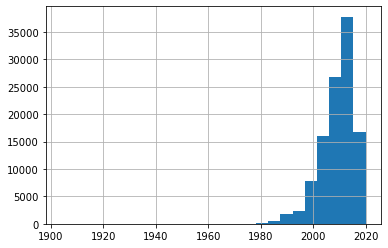

Всего выбросов: 3082  Минимум: 1994.0  Максимум: 2026.0


In [63]:
num_check('production_date')

In [64]:
data[data.temp == 0].production_date.min()

1904

В продаже невероятно старые машины. Создадим новый признак age, в котором будет возраст машины, а этот признак переделаем из колличественного в категориальный.

In [65]:
data.production_date.max()

2020

In [66]:
data['age'] = data.production_date.apply(lambda row: 2020 - row)
data_num.append('age')

In [67]:
def production_date_changer(row):
    if row < 1990:
        return 'rarity'
    elif row < 2010:
        return 'standart'
    else:
        return 'modern'


data.production_date = data.production_date.apply(
    lambda row: production_date_changer(row))

In [68]:
data_cat.append('production_date')


#### vehicle_transmission
Тип коробки передач, категориальный признак, пропусков нет, но необходимо привести к одному виду

In [69]:
data.vehicle_transmission.value_counts()

AUTOMATIC           40771
MECHANICAL          24326
автоматическая      19596
механическая         7209
ROBOT                5792
VARIATOR             4509
вариатор             3999
роботизированная     3882
Name: vehicle_transmission, dtype: int64

In [70]:
transmission = {'автоматическая': 'AUTOMATIC', 'механическая': 'MECHANICAL',
                'вариатор': 'VARIATOR', 'роботизированная': 'ROBOT'}
data.vehicle_transmission.replace(to_replace=transmission, inplace=True)
data_cat.append('vehicle_transmission')
data.vehicle_transmission.value_counts()

AUTOMATIC     60367
MECHANICAL    31535
ROBOT          9674
VARIATOR       8508
Name: vehicle_transmission, dtype: int64

####  vehicle_configuration
Все данные отсюда судя по всему уже присутствуют в других признаках, просто избавимся от него.

In [71]:
data.vehicle_configuration.value_counts()

SEDAN MECHANICAL 1.6                5369
SEDAN AUTOMATIC 1.6                 4138
SEDAN AUTOMATIC 2.0                 3579
ALLROAD_5_DOORS AUTOMATIC 2.0       3439
ALLROAD_5_DOORS AUTOMATIC 3.0       2871
                                    ... 
COMPACTVAN MECHANICAL 7                1
ALLROAD_5_DOORS AUTOMATIC 40e          1
WAGON_5_DOORS MECHANICAL Shuttle       1
ALLROAD_5_DOORS MECHANICAL STi         1
SEDAN AUTOMATIC 4.9d                   1
Name: vehicle_configuration, Length: 1990, dtype: int64

In [72]:
data = data.drop(['vehicle_configuration'], axis=1)

####  vendor 
Относительно интересный признак региона производителя машины. Тут нам нужно будет взять пользуясь данным из тестовой выборки заполнить пустые значения в датасете. Создадим словарь групп региона и бреднов и подставим из него подставим регион в пустые значения.

In [73]:
data.vendor.value_counts()

EUROPEAN    20682
JAPANESE    14004
Name: vendor, dtype: int64

In [74]:
vendor = data.groupby(['vendor', 'brand']).temp.count().index
vendordict = {i: j for j, i in vendor}
data['vendor'] = data.brand.map(vendordict)
data.vendor.value_counts()

EUROPEAN    44265
JAPANESE    28568
Name: vendor, dtype: int64

#### заполнили лишь часть, вероятно большая часть брендов машин не пресутствовала в test, придется видимо заполнять в ручную, но учитывая что большая часть машин в новом списке не из европы или японии было принято решение поделить их на west и east, так как добавлять новые значения, которых не будет в test нет смысла.

In [75]:
newvenddict = {'CADILLAC': 'west', 'CHERY': 'east', 'CHEVROLET': 'west', 'CHRYSLER': 'west', 'CITROEN': 'west', 'DAEWOO': 'east',
               'DODGE': 'west', 'FORD': 'west', 'GEELY': 'east', 'HYUNDAI': 'east', 'JAGUAR': 'west', 'JEEP': 'west', 'KIA': 'east',
               'MAZDA': 'east', 'OPEL': 'west', 'PEUGEOT': 'west', 'PORSCHE': 'west', 'RENAULT': 'west', 'SUBARU': 'east',
               'SUZUKI': 'east', 'GREAT_WALL': 'east', 'LAND_ROVER': 'east', 'SSANG_YONG': 'east'}
vendordict = {**vendordict, **newvenddict}
data['vendor'] = data.brand.map(vendordict)
data.vendor = data.vendor.apply(
    lambda row: 'west' if row == 'EUROPEAN' else row)
data.vendor = data.vendor.apply(
    lambda row: 'east' if row == 'JAPANESE' else row)

In [76]:
data.vendor.value_counts()

west    63073
east    46806
Name: vendor, dtype: int64

так как варианта у нас всего два сделаем признак бинарным

In [77]:
data.vendor = data.vendor.apply(lambda row: 1 if row == 'east' else 0)
data_bin.append('vendor')
data.vendor.value_counts()

0    63278
1    46806
Name: vendor, dtype: int64

####  amount_of_owners
Колличество владельцев машины, категориальный признак(так как у нас идет 1,2, и 3+), нужно привести к общему виду(их опять же 2) и разобраться с пропусками. Они присутствуют лишь в train части, так что их всегда можно просто удалить. Но возможно пропуск означает, что машина продается сразу от произовдителя или ретейлора и владельцев у нее небыло.

In [78]:
data.amount_of_owners = data.amount_of_owners.apply(lambda row: float(
    re.split('\s', row)[0].lstrip()) if re.search('\s', str(row)) else row)

In [79]:
data.amount_of_owners.value_counts()

3.0    52055
2.0    30172
1.0    27857
Name: amount_of_owners, dtype: int64

да, как и ожидалось это новые машины, поставим всем пустым значениям 0.

In [80]:
data_cat.append('amount_of_owners')
data.amount_of_owners.value_counts()

3.0    52055
2.0    30172
1.0    27857
Name: amount_of_owners, dtype: int64

#### car_ownership_time
Большое колличество пропусков в test, без хорошего способа заменить их. Сам по себе признак спорный, и как мне кажется заменяется другими. Удалим его.

In [81]:
data.car_ownership_time.value_counts()

{'year': 2018, 'month': 10}    494
{'year': 2019, 'month': 8}     494
{'year': 2018, 'month': 8}     491
{'year': 2018, 'month': 9}     476
{'year': 2018, 'month': 11}    471
                              ... 
{'year': 2003, 'month': 2}       1
18 лет и 2 месяца                1
{'year': 1997, 'month': 10}      1
{'year': 1990, 'month': 11}      1
{'year': 2001, 'month': 1}       1
Name: car_ownership_time, Length: 565, dtype: int64

In [82]:
data = data.drop(['car_ownership_time'], axis=1)

####  pts
Оригинал или дубликат паспорта транспортного средства, пропусков нет. Приведем к одному виду.

In [83]:
data.pts.value_counts()

ORIGINAL     65022
Оригинал     30098
DUPLICATE    10376
Дубликат      4587
Name: pts, dtype: int64

In [84]:
pts = {'Оригинал': 'ORIGINAL', 'Дубликат': 'DUPLICATE'}
data.pts.replace(to_replace=pts, inplace=True)
data_bin.append('pts')
data.pts = data.pts.apply(lambda row: 1 if row == 'ORIGINAL' else 0)
data.pts.value_counts()

1    95120
0    14964
Name: pts, dtype: int64

#### drive
Тип привода у автомобиля, всего представлено 3. Категориальный признак без пропусков.

In [85]:
data_cat.append('drive')
data.drive.value_counts()

передний    58350
полный      41173
задний      10561
Name: drive, dtype: int64

#### wheel
Бинарный признак без пропусков, приведем к одному виду.

In [86]:
data.wheel.value_counts()

LEFT      73619
Левый     33287
RIGHT      1779
Правый     1399
Name: wheel, dtype: int64

In [87]:
wheel = {'Левый': 'LEFT', 'Правый': 'RIGHT'}
data.wheel.replace(to_replace=wheel, inplace=True)
data.wheel = data.wheel.apply(lambda row: 1 if row == 'RIGHT' else 0)
data_bin.append('wheel')
data.wheel.value_counts()

0    106906
1      3178
Name: wheel, dtype: int64

#### condition
Все машины в тестовой выборке не требуют ремонта, когда как в тренировочной значение пустует. Смысла как мне кажется в этом признаке никакого, удалим его.

In [88]:
data = data.drop(['condition'], axis=1)

#### cleared_by_customs
Еще один бесполезный признак, все автомобили в обеих выборках растаможены, удалим его.

In [89]:
data = data.drop(['cleared_by_customs'], axis=1)

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110084 entries, 0 to 123653
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   body_type             110084 non-null  object 
 1   brand                 110084 non-null  object 
 2   color                 110084 non-null  object 
 3   complectation_dict    81816 non-null   object 
 4   engine_power          110084 non-null  float64
 5   fuel_type             110084 non-null  object 
 6   mileage               110084 non-null  int64  
 7   model_date            110084 non-null  float64
 8   model                 110084 non-null  object 
 9   name                  110084 non-null  float64
 10  number_of_doors       110084 non-null  float64
 11  production_date       110084 non-null  object 
 12  sell_id               34686 non-null   float64
 13  vehicle_transmission  110084 non-null  object 
 14  vendor                110084 non-null  int64  
 15  

#### complectation_dict
В теории из этого признака можно было бы вынуть дополнительные признаки, но его проблема в том, что в тестовой выборке уж слишком много пропусков. Пока что удалим, но возхможно вернемся к нему позже

In [91]:
data = data.drop(['complectation_dict'], axis=1)

Теперь проанализируем столбцы по типам. Для начала посмотрим, какие столбцы какому типу принадлежат.

In [92]:
print('Категориальные: ', data_cat)
print('Колличественные: ', data_num)
print('Бинарные: ', data_bin)

Категориальные:  ['body_type', 'brand', 'color', 'fuel_type', 'model', 'number_of_doors', 'production_date', 'vehicle_transmission', 'amount_of_owners', 'drive']
Колличественные:  ['engine_power', 'mileage', 'model_date', 'name', 'age']
Бинарные:  ['mileage_over_100', 'vendor', 'pts', 'wheel']


#### Колличественные признаки

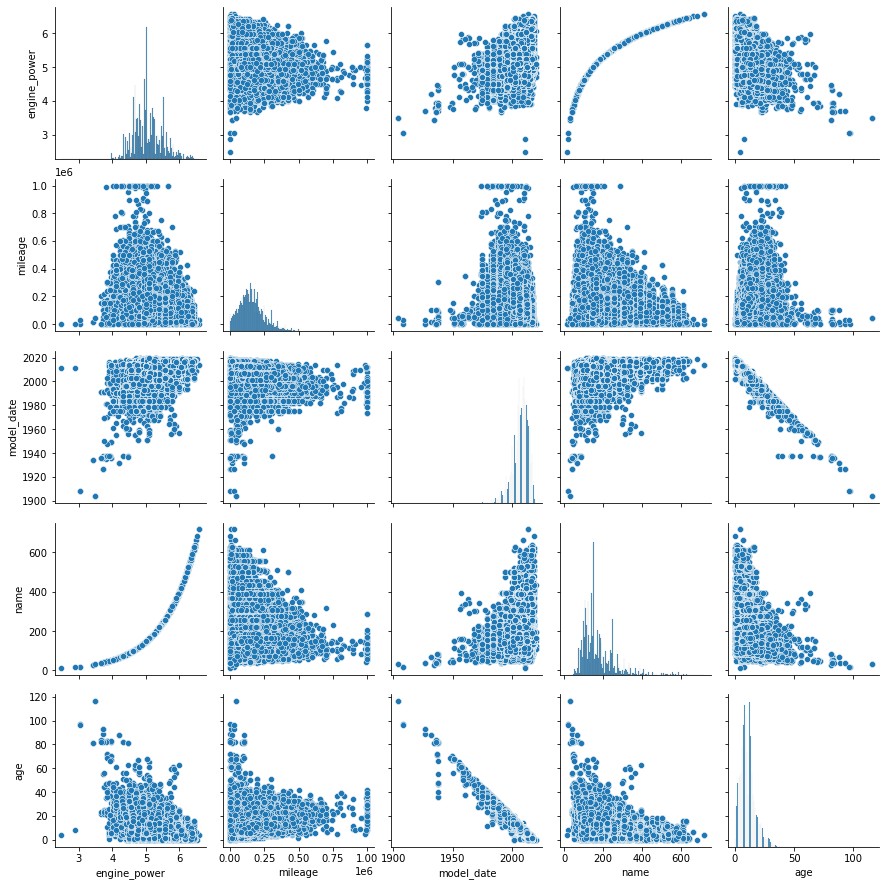

In [93]:
sns.pairplot(data[data_num])

Легко увидеть корреляцию name и engine power(что логично учитывая что в name у нас лошадиные силы машины) и так же model_date и production date.

<AxesSubplot:>

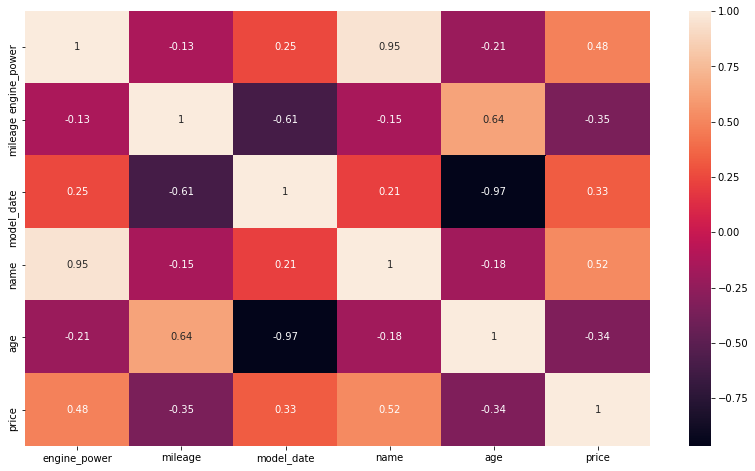

In [94]:
plt.figure(figsize=(14, 8))
sns.heatmap(data[data_num+['price']].corr(), annot=True)

уберем name из-за корреляции 

In [95]:
data = data.drop(['name'], axis=1)
data_num.remove('name')

<AxesSubplot:>

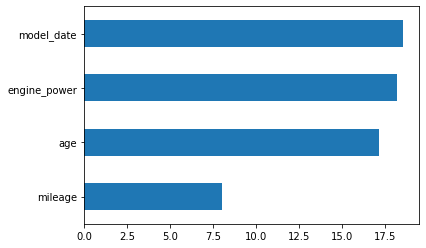

In [96]:
imp_num = pd.Series(f_classif(data[data['price'].isna(
) == False][data_num], data[data['price'].isna() == False]['price'])[0], index=data_num)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

#### Категориальные и бинарные признаки

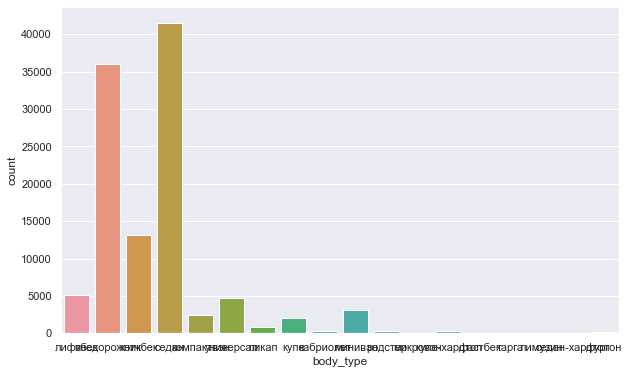

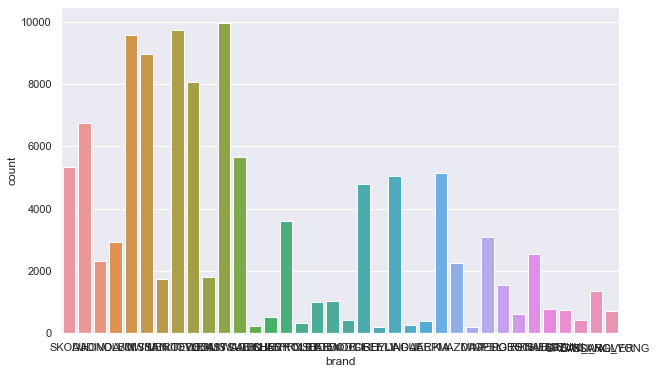

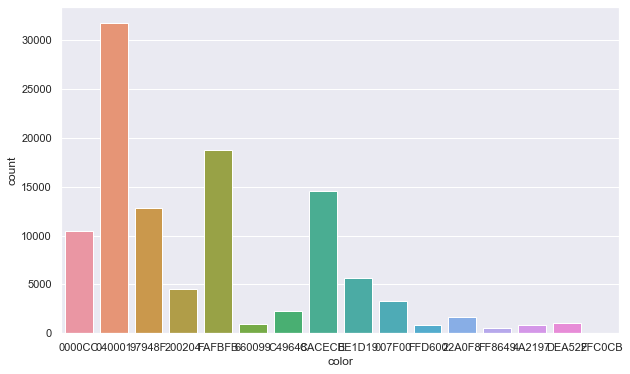

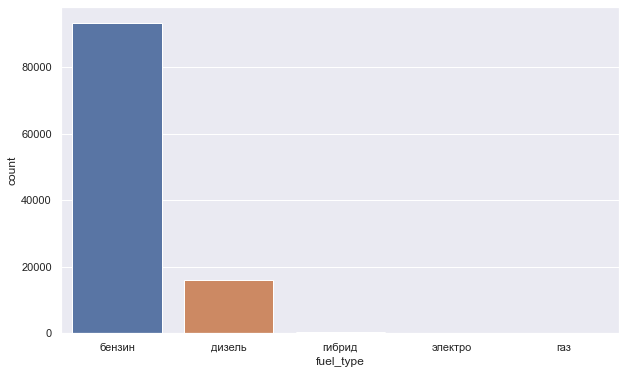

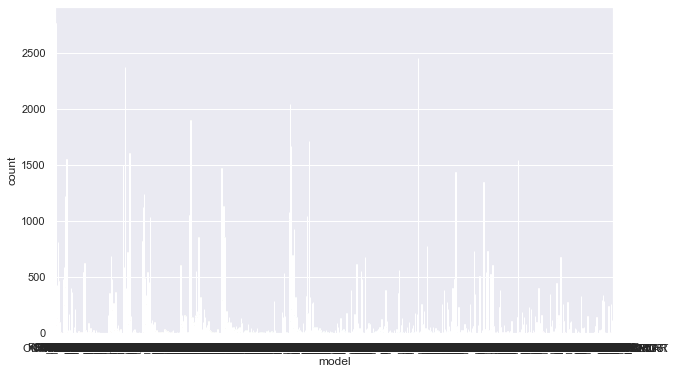

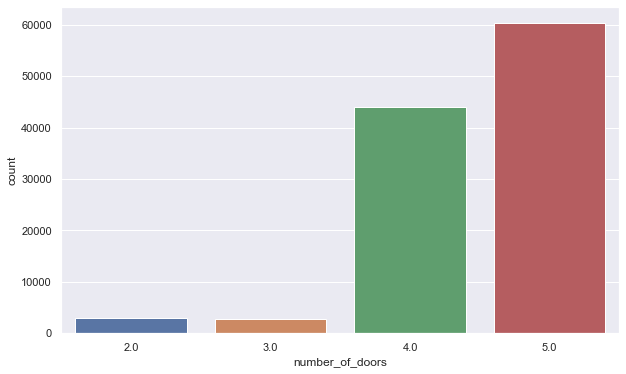

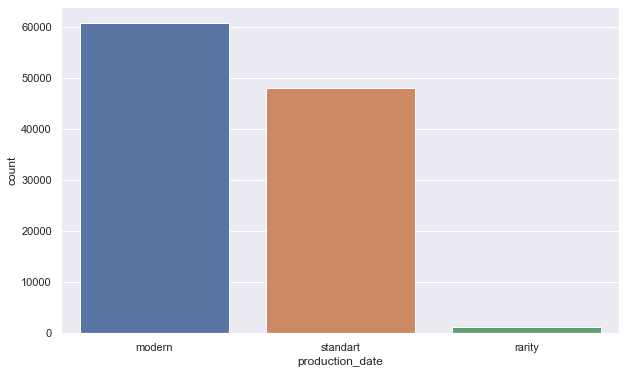

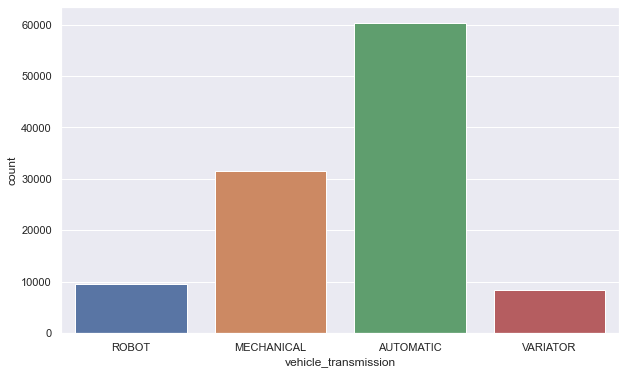

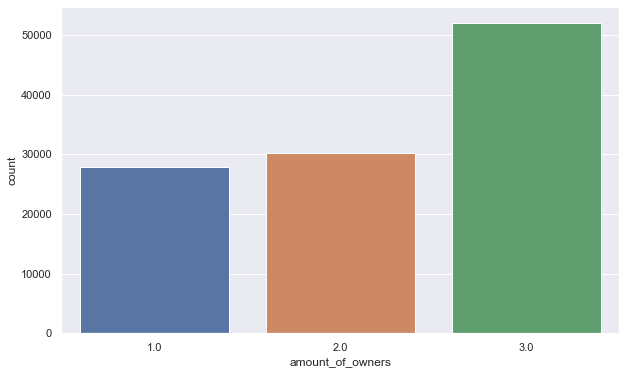

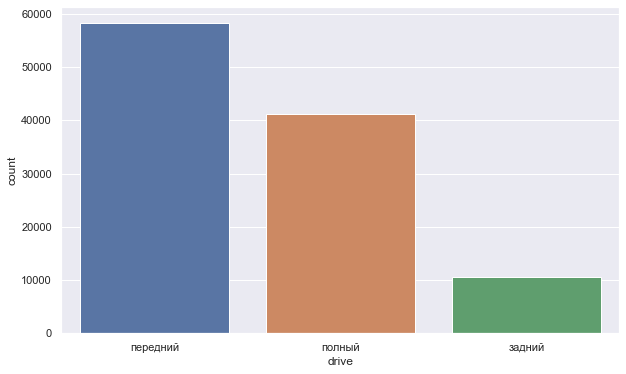

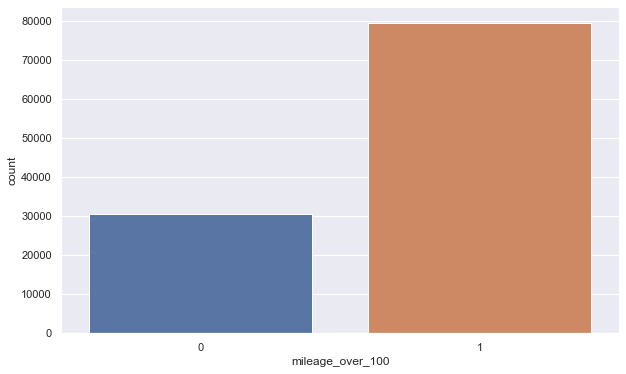

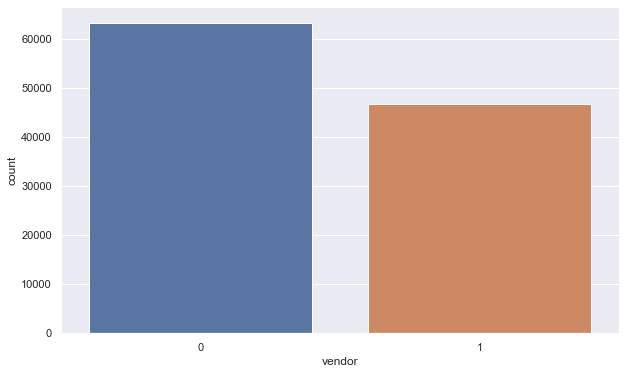

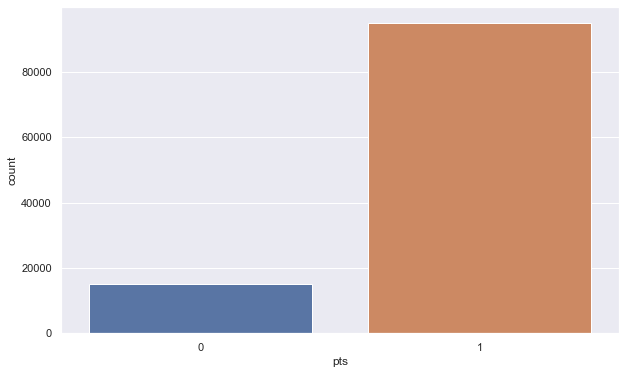

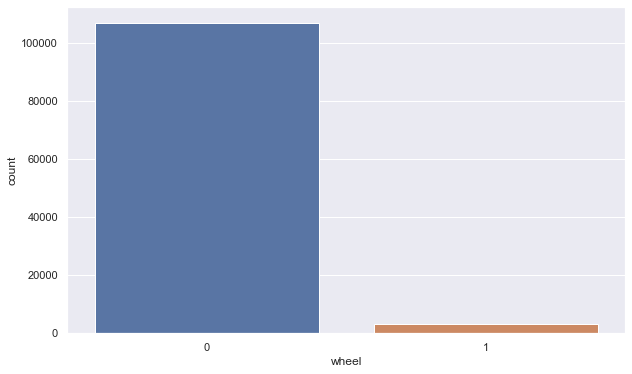

In [97]:
sns.set(rc={'figure.figsize': (10, 6)})
for col in data_cat+data_bin:
    sns.countplot(x=data[col])
    plt.show()

Легко можно выделить, тот факт что у нас много редко встречающихся категорий. Пока что оставим как есть, но позже вероятно избавимся от них. Так же хорошей идеей может быть добавление признаков по типу top 5 модель/цвет/бренд.

<AxesSubplot:>

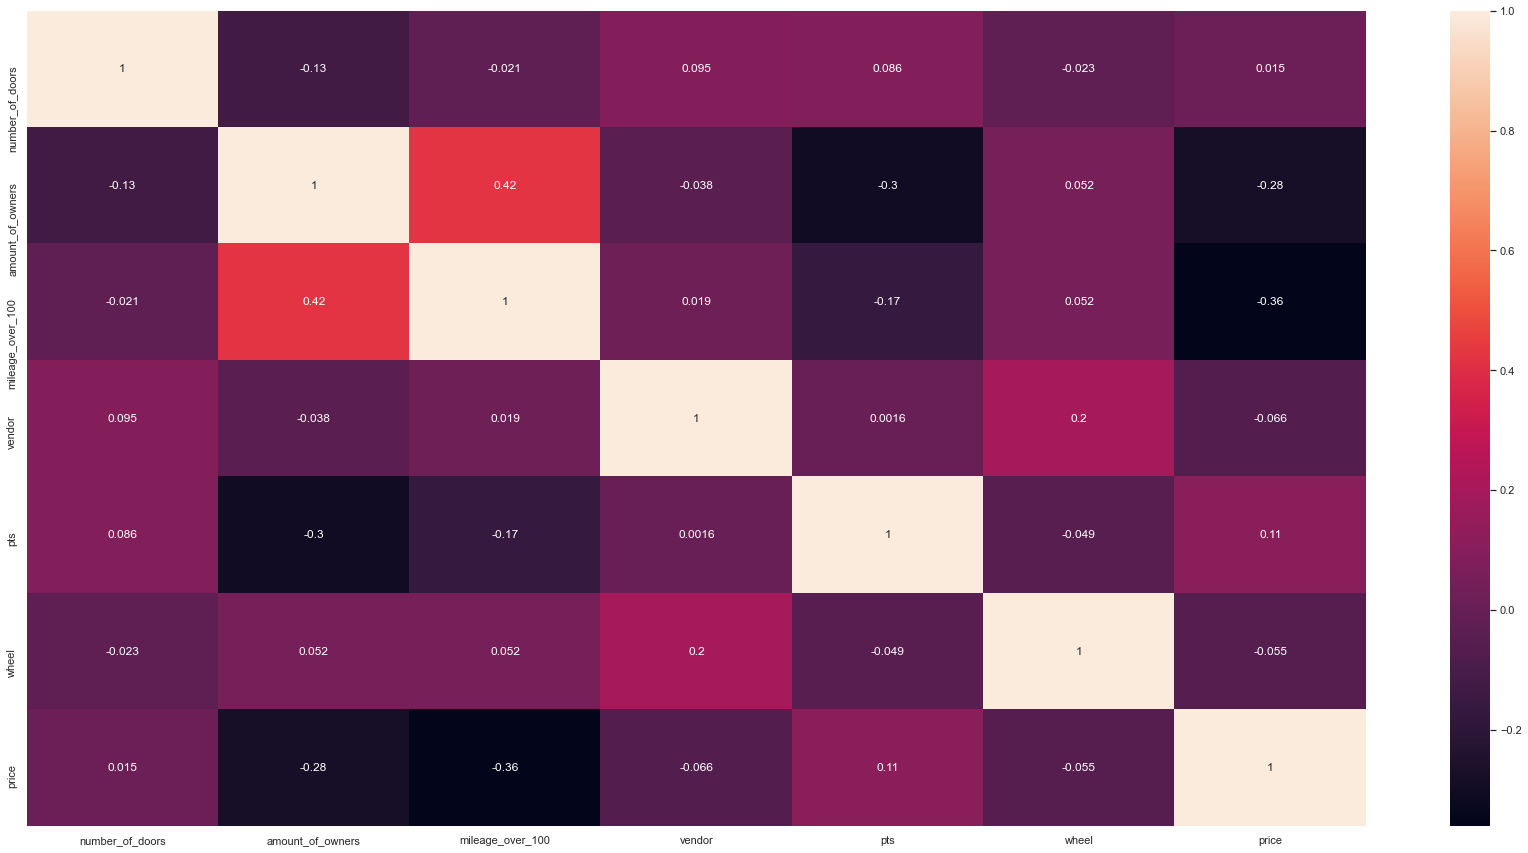

In [98]:
plt.figure(figsize=(30, 15))
sns.heatmap(data[data_cat + data_bin+['price']].corr(), annot=True)

In [99]:
for col in data_cat + data_bin:
    data[col] = data[col].astype('category').cat.codes

<AxesSubplot:>

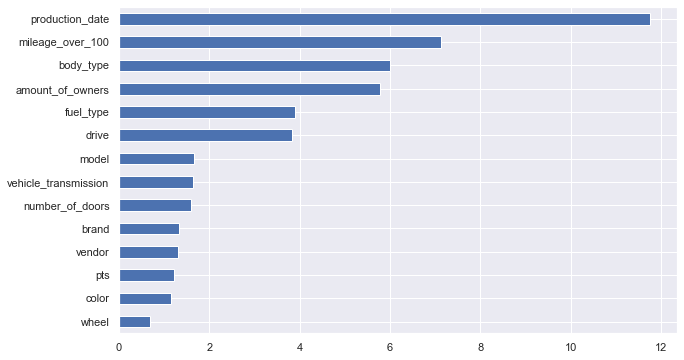

In [100]:
imp_num = pd.Series(f_classif(data[data['price'].isna() == False][data_cat + data_bin],
                    data[data['price'].isna() == False]['price'])[0], index=data_cat + data_bin)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

### Так же разделим, маленькие категориальные признаки на фиктивные переменные, большие оставим такими, какие есть. Колличественные же нормализуем.

In [101]:
data_col_small = ['fuel_type', 'number_of_doors', 'production_date',
                  'vehicle_transmission', 'amount_of_owners', 'drive']
data = pd.get_dummies(data, columns=data_col_small)

In [102]:
data.reset_index(inplace=True)
scaler = MinMaxScaler()
d = scaler.fit_transform(data[data_num])
data[data_num] = pd.DataFrame(d, columns=data_num)
data = data.drop(['index'], axis=1)
data.head()

,body_type,brand,color,engine_power,mileage,model_date,model,sell_id,vendor,pts,...,vehicle_transmission_0,vehicle_transmission_1,vehicle_transmission_2,vehicle_transmission_3,amount_of_owners_0,amount_of_owners_1,amount_of_owners_2,drive_0,drive_1,drive_2
0,6,29,0,0.532445,0.073999,0.939655,679,1.100575e+09,0,1,...,0,0,1,0,0,0,1,0,1,0
1,6,29,2,0.543710,0.060562,0.974138,679,1.100549e+09,0,1,...,0,1,0,0,1,0,0,0,1,0
2,6,29,7,0.622142,0.087999,0.939655,913,1.100658e+09,0,1,...,0,0,1,0,1,0,0,0,1,0
3,6,29,3,0.543710,0.094999,0.939655,679,1.100937e+09,0,1,...,1,0,0,0,1,0,0,0,1,0
4,6,29,12,0.622142,0.058535,0.896552,679,1.101038e+09,0,1,...,1,0,0,0,1,0,0,0,1,0


# Machine learning

In [103]:
x = data[data.temp == 1].drop(['temp', 'price', 'sell_id'], axis=1)
y = data[data.temp == 1].price
x_for_sub = data[data.temp == 0].drop(['temp', 'price', 'sell_id'], axis=1)

In [104]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Model 1: Наивная модель

In [105]:
tmp_train = x_train.copy()
tmp_train['price'] = y_train

In [106]:
predict = x_test['engine_power'].map(
    tmp_train.groupby('engine_power')['price'].median())
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 53.21%


## Model 2: CatBoost

In [107]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(x_train, y_train,
          # cat_features=cat_features_ids,
          eval_set=(x_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )
#оцениваем точность
predict = model.predict(x_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.03%


#### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели.

In [108]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(x_train, np.log(y_train),
          # cat_features=cat_features_ids,
          eval_set=(x_test, np.log(y_test)),
          verbose_eval=0,
          use_best_model=True,
          # plot=True
          )
predict_test = np.exp(model.predict(x_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.43%


сабмит 13.04703

Улучшение на 2.5%
### Model 3: RandomForestRegressor
Для начала попробуем посмотреть на точность метрики без подбора гиперпараметров

In [109]:
rfr = RandomForestRegressor(random_state=RANDOM_SEED)
rfr.fit(x_train, y_train)
predict_test = rfr.predict(x_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 15.80%


In [110]:
rfr_log = RandomForestRegressor(random_state=RANDOM_SEED)
rfr_log.fit(x_train, np.log(y_train))
predict_test = np.exp(rfr_log.predict(x_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.37%


#### Подберем гиперпараметры.

In [111]:
# random_grid = {'n_estimators': range(100,1000,10),
#               'max_features': ['auto','sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=10)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}
#
#rfr = RandomForestRegressor(random_state=RANDOM_SEED)
# rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
#                               n_iter=100, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)
#
#rfr_random.fit(x_train, np.log(y_train))
# rfr_random.best_params_

Мощностей моего комьпютера явно не хватает, чтобы быстро подбирать гиперпараметры, спустя 2 часа такой результат.

{'n_estimators': 120,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [112]:
param_log_rfr = RandomForestRegressor(n_estimators=120, min_samples_split=10, min_samples_leaf=1,
                                      max_features='auto', max_depth=None, bootstrap=True, random_state=RANDOM_SEED)
param_log_rfr.fit(x_train, np.log(y_train))
predict_test = np.exp(param_log_rfr.predict(x_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 14.18%


12.95945 сабмит 
Результаты слегка улучшились.
### Model 4: XGBRegresson

In [113]:
xgboost = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                           learning_rate=0.05, max_depth=15, alpha=1, n_jobs=-1, n_estimators=900)
xgboost.fit(x_train, np.log(y_train+1))
predict_test = np.exp(xgboost.predict(x_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.44%


11.35575 сабмит

#### Model 6: StackingRegressor
Для стека возьмем модели с лучшими результатами XGBoost и RandomForestRegressor 

In [114]:
estimators = [('xgboost', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05,
                                           max_depth=15, alpha=1, n_jobs=-1, n_estimators=900)),
              ('xgboost2', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05,
                                            max_depth=15, alpha=1, n_jobs=-1, n_estimators=900)),
              ('param_log_rfr', RandomForestRegressor(n_estimators=120, min_samples_split=10, min_samples_leaf=1,
                                                      max_features='auto', max_depth=None, bootstrap=True,
                                                      random_state=RANDOM_SEED))
              ]

последним возьмем линейную регрессию

In [115]:
stack_reg = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression())
stack_reg.fit(x_train, np.log(y_train))

StackingRegressor(estimators=[('xgboost',
                               XGBRegressor(alpha=1, base_score=None,
                                            booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05,
                                            max_delta_step=None, max_depth=15,
                                            min_child_weight=None, missing=nan,
                                            monotone_...
                                            monotone_constraints=None,

In [116]:
predict = np.exp(stack_reg.predict(x_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 13.35%


In [117]:
predict_submission = np.exp(stack_reg.predict(x_for_sub))
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head()

,sell_id,price
0,1100575026,607037.685300
1,1100549428,910697.721536
2,1100658222,945014.729491
3,1100937408,706194.318601
4,1101037972,718670.837604
